In [226]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy.signal import stft,istft
import IPython.display as ipd
import torch 
import torch.nn as nn
import h5py  
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import os
import re
import scipy.io.wavfile as wav
from glob import glob
import pandas as pd

## Séparation de sources, projet


In [204]:
fe1, data1 = scipy.io.wavfile.read("train_small/0000/mix_snr_3.wav")
print("Signal brut : mix_snr_3.wav")
display(ipd.Audio(data1, rate=fe1))

fe2, data2 = scipy.io.wavfile.read("train_small/0000/noise.wav")
print("Bruit : noise.wav")
display(ipd.Audio(data2, rate=fe2))

fe3, data3 = scipy.io.wavfile.read("train_small/0000/voice.wav")
print("Voix : voice.wav")
display(ipd.Audio(data3, rate=fe3))

Signal brut : mix_snr_3.wav


Bruit : noise.wav


Voix : voice.wav


In [205]:
fe1, data1 = scipy.io.wavfile.read("train_small/0002/mix_snr_-2.wav")
print("Signal brut : mix_snr_-2.wav")
display(ipd.Audio(data1, rate=fe1))

fe2, data2 = scipy.io.wavfile.read("train_small/0000/noise.wav")
print("Bruit : noise.wav")
display(ipd.Audio(data2, rate=fe2))

fe3, data3 = scipy.io.wavfile.read("train_small/0000/voice.wav")
print("Voix: voice.wav")
display(ipd.Audio(data3, rate=fe3))


Signal brut : mix_snr_-2.wav


Bruit : noise.wav


Voix: voice.wav


La première chose que j'aimerais voir c'est la distribution des SNR sur l'ensemble des données d'entraînement et de test, afin de voir si les distributions de SNR sont similaires.

In [206]:
dossier_principal = "train"
pattern = re.compile(r"mix_snr_([+-]?\d+)")
snr_values = []

for sous_dossier in os.listdir(dossier_principal):
    chemin_sous_dossier = os.path.join(dossier_principal, sous_dossier)
    if os.path.isdir(chemin_sous_dossier):  
        fichiers = os.listdir(chemin_sous_dossier)
        for fichier in fichiers:
            match = pattern.search(fichier)
            if match:
                snr_value = int(match.group(1))
                snr_values.append(snr_value)

df_snr = pd.DataFrame(snr_values, columns=["SNR"])

df_snr_counts = df_snr["SNR"].value_counts().reset_index()
df_snr_counts.columns = ["SNR", "Occurrence"]
df_snr_counts = df_snr_counts.sort_values(by="SNR", ascending=True).reset_index(drop=True)

print(df_snr_counts)


   SNR  Occurrence
0   -4         516
1   -3         450
2   -2         507
3   -1         506
4    0        1001
5    1         506
6    2         485
7    3         509
8    4         520


In [207]:
dossier_principal = "test"
pattern = re.compile(r"mix_snr_([+-]?\d+)")
snr_values = []

for sous_dossier in os.listdir(dossier_principal):
    chemin_sous_dossier = os.path.join(dossier_principal, sous_dossier)
    if os.path.isdir(chemin_sous_dossier):  
        fichiers = os.listdir(chemin_sous_dossier)
        for fichier in fichiers:
            match = pattern.search(fichier)
            if match:
                snr_value = int(match.group(1))
                snr_values.append(snr_value)

df_snr = pd.DataFrame(snr_values, columns=["SNR"])

df_snr_counts = df_snr["SNR"].value_counts().reset_index()
df_snr_counts.columns = ["SNR", "Occurrence"]
df_snr_counts = df_snr_counts.sort_values(by="SNR", ascending=True).reset_index(drop=True)

print(df_snr_counts)


   SNR  Occurrence
0   -4         206
1   -3         207
2   -2         205
3   -1         201
4    0         395
5    1         209
6    2         171
7    3         206
8    4         200


La structure est similaire pour les ensembles de train et de test.

## Deep U-Net convolutional networks
L'objectif est de mettre en place l'architecture proposée par l'article "SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORKS" dans le cadre de la séparation chanteur-instrumental pour notre problème de séparation de sources. Dans un premier temps, on va essayer de quantifier les résultats qu'on obtient via les paramètres de l'article puis on essaiera de jouer avec certains paramètres pour améliorer les performances. On réalise l'apprentissage sur le spectrogramme normalisé. Pour coller avec l'article (au niveau des dimensions de l'architecture), on va récupérer seulement les 128 données temporelles du spectrogramme, faisant cela, on ne perd pas de structure car le bruit reste constant au sein d'un même enregistrement, on diminue simplement la taille des données. 

In [228]:
def to_spectrogram(data, fe):
    nb = 1022
    nperseg = nb  
    noverlap = nb // 2 
    f, tfct, Zxx = stft(data, fs=fe, nperseg=nperseg, nfft=nb, noverlap=noverlap, window='hamming')
    target_columns = 128
    Zxx_resized = Zxx[:, :target_columns]
    Zxx_magnitude = np.abs(Zxx_resized)**2
    Zxx_normalized = (Zxx_magnitude - np.min(Zxx_magnitude)) / (np.max(Zxx_magnitude)-np.min(Zxx_magnitude))
    return Zxx_normalized


In [209]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dir):
        self.dir = dir
        self.files = []
        
        for subfolder in os.listdir(dir):
            subfolder_path = os.path.join(dir, subfolder)
            if os.path.isdir(subfolder_path):
                mix = glob(os.path.join(subfolder_path, "mix*.wav"))
                noise = glob(os.path.join(subfolder_path, "noise.wav"))
                voice = glob(os.path.join(subfolder_path, "voice.wav"))
                
                if mix and noise and voice:
                    self.files.append((mix[0], noise[0], voice[0]))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        mix_path, noise_path, voice_path = self.files[idx]
        sample_rate, waveform = scipy.io.wavfile.read(mix_path)  
        #convertir en spectogramme
        spectrogram = to_spectrogram(waveform, fe=sample_rate)
        return torch.tensor(spectrogram), mix_path, noise_path, voice_path


In [210]:
dir_path = 'train/'  

dataset = MyDataset(dir=dir_path)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Spectrogrammes shape: {spectrograms.shape}")    
    print(f"Exemple de mix_path: {mix_path[0]}")
    print(f"Exemple de noise_path: {noise_path[0]}")
    print(f"Exemple de voice_path: {voice_path[0]}")
    
    if batch_idx >= 2: 
        break


Batch 1:
Spectrogrammes shape: torch.Size([4, 512, 128])
Exemple de mix_path: train/2523\mix_snr_3.wav
Exemple de noise_path: train/2523\noise.wav
Exemple de voice_path: train/2523\voice.wav
Batch 2:
Spectrogrammes shape: torch.Size([4, 512, 128])
Exemple de mix_path: train/2136\mix_snr_-4.wav
Exemple de noise_path: train/2136\noise.wav
Exemple de voice_path: train/2136\voice.wav
Batch 3:
Spectrogrammes shape: torch.Size([4, 512, 128])
Exemple de mix_path: train/3137\mix_snr_3.wav
Exemple de noise_path: train/3137\noise.wav
Exemple de voice_path: train/3137\voice.wav


Maintenant, on peut coder le modèle U-Net proposé par l'article.

In [211]:
class u_net_source_separation(nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        #encode
        self.conv1 = nn.Conv2d(1,16,kernel_size=5,stride=2,padding=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=5,stride=2,padding=2)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size=5,stride=2,padding=2)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,kernel_size=5,stride=2,padding=2)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,512,kernel_size=5,stride=2,padding=2)
        self.batch_norm6 = nn.BatchNorm2d(512)

        #decode
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm1_d = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.5)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm2_d = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.5)
        self.deconv3 = nn.ConvTranspose2d(256, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm3_d = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(0.5)
        self.deconv4 = nn.ConvTranspose2d(128, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm4_d = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(64, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm5_d = nn.BatchNorm2d(16)
        self.deconv6 = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm6_d = nn.BatchNorm2d(1)

        #activation
        self.Lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #encode
        x = self.Lrelu(self.batch_norm1(self.conv1(x)))
        x1 = x.clone()
        x = self.Lrelu(self.batch_norm2(self.conv2(x)))
        x2 = x.clone()
        x = self.Lrelu(self.batch_norm3(self.conv3(x)))
        x3 = x.clone()
        x = self.Lrelu(self.batch_norm4(self.conv4(x)))
        x4 = x.clone()
        x = self.Lrelu(self.batch_norm5(self.conv5(x)))
        x5 = x.clone()
        x = self.Lrelu(self.batch_norm6(self.conv6(x)))
        #decode
        x = self.relu(self.batch_norm1_d(self.deconv1(x)))
        x = self.dropout1(x)
        x = torch.cat([x, x5], dim=1)
        x = self.relu(self.batch_norm2_d(self.deconv2(x)))
        x = self.dropout2(x)
        x = torch.cat([x, x4], dim=1)
        x = self.relu(self.batch_norm3_d(self.deconv3(x)))
        x = self.dropout3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.relu(self.batch_norm4_d(self.deconv4(x)))
        x = torch.cat([x, x2], dim=1)
        x = self.relu(self.batch_norm5_d(self.deconv5(x)))
        x = torch.cat([x, x1], dim=1)
        x = self.sigmoid(self.batch_norm6_d(self.deconv6(x)))
        return x
    

model = u_net_source_separation()
dummy_input = torch.randn(5,1,512,128)
output = model(dummy_input)
print(output.shape)

torch.Size([5, 1, 512, 128])


On va essayer d'apprendre le masque qui permet d'isoler la voix. La fonction de perte utilisée est la norme $L_1$ de la matrice du spectrogramme complet multipliée avec le masque comparé à la matrice du spectrogramme de la voix isolée.

In [212]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        
    def forward(self, mask, input, target):
        return torch.sum(torch.abs((mask*input)-target))

In [213]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Mode validation
    val_loss = 0.0

    with torch.no_grad(): 
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(val_loader):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []
            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            mask = model(spectrograms)
            loss = criterion(mask, spectrograms, target)
            val_loss += loss.item()

    return val_loss / len(val_loader)

On peut réaliser l'entraînement.

In [219]:
# Paramètres de l'entraînement
num_epochs = 10
batch_size = 25
learning_rate = 0.0001

train = 'train/'  
dataset_train = MyDataset(dir=train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

test = 'test/'
dataset_test = MyDataset(dir=test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

model = u_net_source_separation()
criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cpu'
model.to(device)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_train):
        spectrograms = spectrograms.to(device).unsqueeze(1)  

        target_spectrograms = []

        for vp in voice_path:
            sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
            target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
            target_spectrograms.append(target_spectrogram)
        
        target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

        optimizer.zero_grad()

        #forward pass
        output = model(spectrograms)

        loss = criterion(output, spectrograms, target)

        #backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 50 == -1:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss moyenne: {running_loss / len(dataloader):.4f}")
    
    model.eval() 
    valid_loss = 0.0

    with torch.no_grad():  
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_test):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []

            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            # Forward pass
            output = model(spectrograms)

            # Calcul de la perte
            loss = criterion(output, spectrograms, target)
            valid_loss += loss.item()

        # Moyenne de la perte sur le dataset de test
        valid_loss /= len(dataloader_test)

    print(f"Validation Loss après l'époque {epoch + 1}: {valid_loss:.4f}")


# Sauvegarder le modèle
torch.save(model.state_dict(), "u_net_source_separation.pth")


Epoch [1/10] - Loss moyenne: 76.2351
Validation Loss après l'époque 1: 311.4255
Epoch [2/10] - Loss moyenne: 49.9877
Validation Loss après l'époque 2: 275.4773
Epoch [3/10] - Loss moyenne: 46.0611
Validation Loss après l'époque 3: 260.1510
Epoch [4/10] - Loss moyenne: 43.7631
Validation Loss après l'époque 4: 253.4987
Epoch [5/10] - Loss moyenne: 42.1370
Validation Loss après l'époque 5: 248.6592
Epoch [6/10] - Loss moyenne: 40.9324
Validation Loss après l'époque 6: 255.2684
Epoch [7/10] - Loss moyenne: 39.9250
Validation Loss après l'époque 7: 238.0665
Epoch [8/10] - Loss moyenne: 39.1037
Validation Loss après l'époque 8: 233.8915
Epoch [9/10] - Loss moyenne: 38.3794
Validation Loss après l'époque 9: 234.7197
Epoch [10/10] - Loss moyenne: 37.8433
Validation Loss après l'époque 10: 229.4897


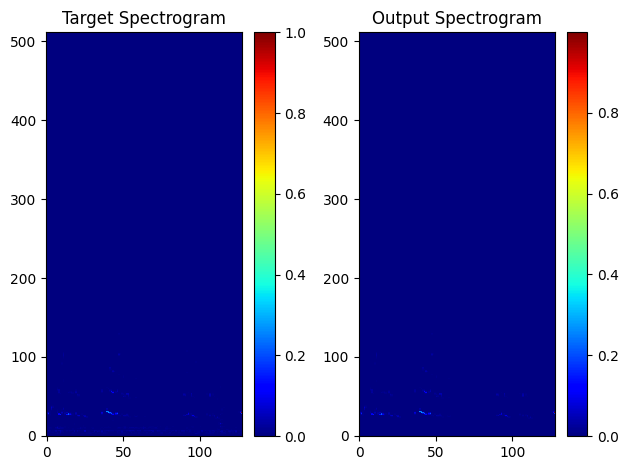

In [256]:
model = u_net_source_separation()
model.load_state_dict(torch.load('u_net_source_separation.pth',weights_only=True))
model.eval()  
sample = 'test/0001/mix_snr_2.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram = to_spectrogram(data, fe=fe)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()
device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)
output_spectrogram = (output.squeeze().cpu().numpy())*input_spectrogram

sample_target = 'test/0001/voice.wav'
fe, data = scipy.io.wavfile.read(sample)
target_spectrogram = to_spectrogram(data, fe=fe)

plt.subplot(1, 2, 1)
plt.imshow(target_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Target Spectrogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(output_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Output Spectrogram')
plt.colorbar()

plt.tight_layout()
plt.show()

Il n'y a pas grand chose sur le graphique mais dès qu'il y a quelque chose, on voit l'équivalent.